In [79]:
import os
import random

random.seed(43)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger().setLevel(logging.ERROR)

import torch
import torch.nn as nn
from torchsummary import summary

import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
# find device
if torch.cuda.is_available(): # NVIDIA
    device = torch.device('cuda')
elif torch.backends.mps.is_available(): # apple silicon
    device = torch.device('mps') 
else:
    device = torch.device('cpu') # fallback
device

device(type='mps')

In [81]:
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')
num_cpus = 1

8 CPUs available


# Preparing the dataset

In [82]:
dataai="../data/WISDM_ar_v1.1/"
datapath = dataai
col_names = ['user', 'activity', 'timestamp', 'x-accel', 'y-accel', 'z-accel']

df = pd.read_csv(datapath+"WISDM_ar_v1.1_raw.txt",
                  header=None, names=col_names, delimiter=',', comment=';',
                    on_bad_lines='skip') #skip/warn bad lines
print(df.shape)
df.head()

(1086471, 6)


,user,activity,timestamp,x-accel,y-accel,z-accel
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [83]:
num_usrs = df['user'].unique()
print(num_usrs.shape)

(36,)


In [84]:
class_labels = df.activity.unique()
num_channels =3 # x-accel, y-accel, z-accel
num_classes = len(class_labels)
print(class_labels)

['Jogging' 'Walking' 'Upstairs' 'Downstairs' 'Sitting' 'Standing']


In [85]:
activity_to_label = {activity: i for i, activity in enumerate(df['activity'].unique())}
print(activity_to_label)

{'Jogging': 0, 'Walking': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}


In [86]:
# Group by users and activity
grouped = df.groupby(['user', 'activity'])

In [87]:
# Combine X, Y, Z into a single time-series for each group
time_series = []
labels = []
activity_to_label = {activity: i for i, activity in enumerate(df['activity'].unique())}
print(activity_to_label)

for (user, activity), group in grouped:
    # Stack X, Y, Z into a single array of shape (timesteps, 3)
    series = np.column_stack((group['x-accel'], group['y-accel'], group['z-accel']))
    time_series.append(series)
    labels.append(activity_to_label[activity])
    

print(time_series[0].shape)
print(len(labels), np.unique(labels, return_counts=True))

{'Jogging': 0, 'Walking': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}
(2941, 3)
179 (array([0, 1, 2, 3, 4, 5]), array([32, 36, 32, 32, 23, 24]))


In [88]:
# Pad/truncate to a fixed length
max_length = 4*1000  # Choose a fixed length
padded_series = nn.utils.rnn.pad_sequence([torch.tensor(series, dtype=torch.float32) for series in time_series],
                             batch_first=True, padding_value=0)
print(padded_series.shape)
padded_series = padded_series[:, :max_length, :]  # Truncate to max_length if necessary


# Normalize (not needed here, but keep it for plotting)
# padded_series = nn.functional.normalize(padded_series, dim=2, p=2)
print(padded_series.shape, len(labels))


torch.Size([179, 17622, 3])
torch.Size([179, 4000, 3]) 179


In [89]:
# add segments
segment_duration = 100
# Calculate the number of segments per sample
num_segments = padded_series.shape[1] // segment_duration
print(" shape of all segmented data", padded_series.shape[0]*num_segments, segment_duration, padded_series.shape[2])
reshaped_data = padded_series.reshape(padded_series.shape[0], num_segments, segment_duration, padded_series.shape[2])

valid_segments = []
valid_labels = []

# Iterate over each sample and its segments to remove segments with all zeros x,y,z
for sample_idx in range(reshaped_data.shape[0]):
    for segment_idx in range(reshaped_data.shape[1]):
        segment = reshaped_data[sample_idx, segment_idx]
        if not (torch.all(segment[:, 0]==0) and torch.all(segment[:, 1]==0) and torch.all(segment[:, 2]==0) ):
            valid_segments.append(segment)
            valid_labels.append(labels[sample_idx])

padded_series = torch.stack(valid_segments)
labels = torch.tensor(valid_labels)
max_length = segment_duration
print(" shape of segmented data with nonzero features",padded_series.shape, labels.shape)
 



 shape of all segmented data 7160 100 3
 shape of segmented data with nonzero features torch.Size([5725, 100, 3]) torch.Size([5725])


upsampling: SMOTE
torch.Size([6683, 100, 3])
[0 1 2 3 4 5] tensor([0.9078, 0.7735, 1.0228, 1.1183, 2.2685, 0.7735])
tensor(6.8644)


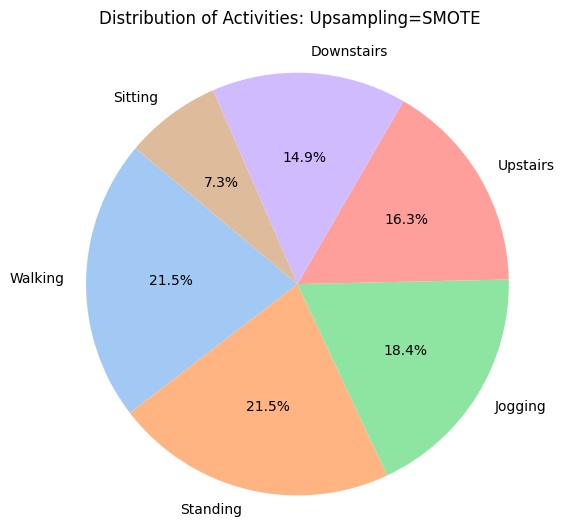

upsampling: ADASYN
torch.Size([6682, 100, 3])
[0 1 2 3 4 5] tensor([0.9076, 0.7734, 1.0227, 1.1181, 2.2682, 0.7739])
tensor(6.8639)


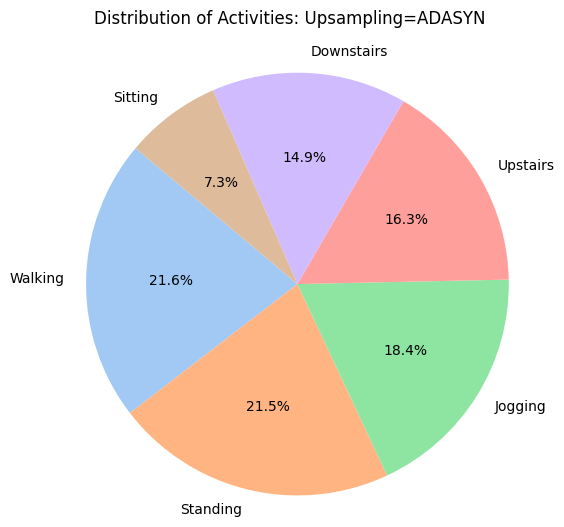

In [90]:
from imblearn.over_sampling import SMOTE, ADASYN


num_sample, timesample, channels = padded_series.shape
padded_series = padded_series.reshape(num_sample, timesample*channels)

# upsampling
upsamples = ["SMOTE", "ADASYN"]
for upsample in upsamples:
    print("upsampling:", upsample)
    if upsample == "SMOTE":
        upsampling = SMOTE(sampling_strategy = 'minority', random_state=43)    
    else:
        upsampling = ADASYN(sampling_strategy = 'minority', random_state=43)
    padded_series_up, labels_up = upsampling.fit_resample(padded_series, labels)
    num_sample, timesample = padded_series_up.shape
    padded_series_up = padded_series_up.reshape(num_sample, timesample//channels, channels)
    padded_series_up = torch.tensor(padded_series_up, dtype=torch.float32)
    print(padded_series_up.shape)

    ynumpy_up = np.array(labels_up)
    class_weights=class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(ynumpy_up), y=ynumpy_up) 
    class_weights=torch.tensor(class_weights,dtype=torch.float)

    print(np.unique(ynumpy_up),class_weights)
    print(class_weights.sum(axis=0))

    df_ynumpy_up = pd.DataFrame(ynumpy_up, columns=["activity"])
    activity_to_label_rev = {i: activity for activity, i in activity_to_label.items()}
    df_ynumpy_up["activity"] = df_ynumpy_up["activity"].map(activity_to_label_rev)

    #Plotting the distribution of activities
    plt.figure(figsize=(6, 6))

    plt.pie(df_ynumpy_up["activity"].value_counts(), labels=df_ynumpy_up["activity"].value_counts().index,
            autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel", n_colors=len(df_ynumpy_up["activity"].value_counts())))
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f"Distribution of Activities: Upsampling={upsample}   \n")
    plt.show()


downupsampling: SMOTEENN
torch.Size([5008, 100, 3])
[0 1 2 3 4 5] tensor([1.0204, 1.2347, 2.5525, 2.6330, 0.5816, 0.5816])
tensor(8.6039)


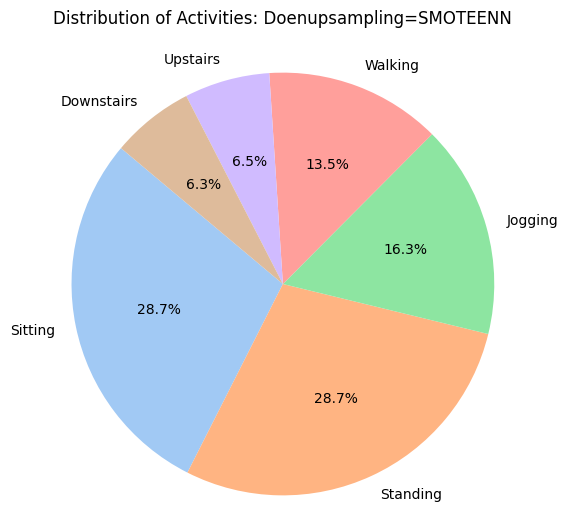

downupsampling: SMOTETomek
torch.Size([8638, 100, 3])
[0 1 2 3 4 5] tensor([0.9998, 0.9998, 1.0005, 0.9998, 0.9998, 1.0005])
tensor(6.)


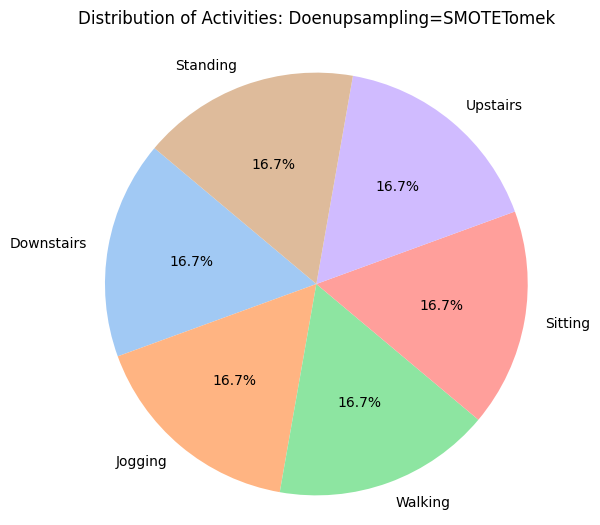

In [91]:
from imblearn.combine import SMOTEENN,SMOTETomek


# downsampling
doupsamples = [ "SMOTEENN" , "SMOTETomek"]
for doupsample in doupsamples:
    print("downupsampling:", doupsample)
    if doupsample == "SMOTEENN":
        doupsampling = SMOTEENN(random_state=43)   #this reduced the samples alot and it is best not to use it
    else:
        doupsampling = SMOTETomek(random_state=43)   

    padded_series_doup, labels_doup = doupsampling.fit_resample(padded_series, labels)
    num_sample, timesample = padded_series_doup.shape
    padded_series_doup = padded_series_doup.reshape(num_sample, timesample//channels, channels)
    padded_series_doup = torch.tensor(padded_series_doup, dtype=torch.float32)
    print(padded_series_doup.shape)

    ynumpy_doup = np.array(labels_doup)
    class_weights=class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(ynumpy_doup), y=ynumpy_doup) 
    class_weights=torch.tensor(class_weights,dtype=torch.float)

    print(np.unique(ynumpy_doup),class_weights)
    print(class_weights.sum(axis=0))



    df_ynumpy_doup = pd.DataFrame(ynumpy_doup, columns=["activity"])
    activity_to_label_rev = {i: activity for activity, i in activity_to_label.items()}
    df_ynumpy_doup["activity"] = df_ynumpy_doup["activity"].map(activity_to_label_rev)

    #Plotting the distribution of activities
    plt.figure(figsize=(6, 6))

    plt.pie(df_ynumpy_doup["activity"].value_counts(), labels=df_ynumpy_doup["activity"].value_counts().index,
            autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel", n_colors=len(df_ynumpy_doup["activity"].value_counts())))
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f"Distribution of Activities: Doenupsampling={doupsample}\n")
    plt.show()